In [1]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
sys.path.append('..') 
import platform
import os
from pathlib import Path
import shutil
from pathlib import Path
import shutil
from utils.behavior.session_utils import load_session_df, parse_session_string
from utils.behavior.lick_analysis import clean_up_licks, parse_lick_trains
from scipy.io import loadmat
from itertools import chain
from matplotlib import pyplot as plt
from IPython.display import display
from scipy.signal import find_peaks
from harp.clock import align_timestamps_to_anchor_points
from utils.basics.data_org import *
from utils.photometry.preprocessing import * 
from utils.photometry.plot_utils import align_signal_to_events, color_gradient, plot_FP_with_licks
import numpy as np
from scipy.signal import butter, filtfilt, medfilt, sosfiltfilt
from scipy.optimize import curve_fit
import json
from sklearn.linear_model import LinearRegression
from matplotlib.gridspec import GridSpec
import pickle
from aind_fip_dff.utils.preprocess import batch_processing, tc_triexpfit
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import time
from contextlib import redirect_stdout
# %matplotlib inline
# %matplotlib widget

### Signle session

In [5]:
session = 'mKJ005d20230624'
label = 'G'
session_dir = parse_session_string(session)
session_df, licks_L, licks_R = load_session_df(session)
licks_L, licks_R, fig = clean_up_licks(licks_L, licks_R, plot=False)
parsed_licks_L, _ = parse_lick_trains(licks_L)
parsed_licks_R, _ = parse_lick_trains(licks_R)
signal_region = load_session_FP(session, label, plot=False);
signal_region_raw = load_session_FP_raw(session, label, plot=False);
# signal_pre = preprocess_signal(session, label, fs = 20, lowcut = 0.1, fc = 9, xtol=1e-6, plot=True, deep=False)

Region mPFC recorded at fiber 0
Region LCN recorded at fiber 1
Region LC recorded at fiber 2
Region mPFC recorded at fiber 0
Region LCN recorded at fiber 1
Region LC recorded at fiber 2
Channel G:Region mPFC recorded at fiber 0
Channel G:Region LCN recorded at fiber 1
Channel G:Region LC recorded at fiber 2
Channel Iso:Region mPFC recorded at fiber 0
Channel Iso:Region LCN recorded at fiber 1
Channel Iso:Region LC recorded at fiber 2


## Test for peak detection

In [ ]:
session = 'm749624d20250109'
signal_FP, signal_params = get_FP_data(session)


Loaded m749624d20250109_combined.pkl and m749624d20250109_combined_params.pkl


In [ ]:
session = 'm749624d20250109'
def peak_detect_FP(session, plot = False):
    signal_FP, _ = get_FP_data(session)
    sos = butter(2, 2, 'low', fs=20, output='sos')
    peaks = {}
    peak_amps = {}
    xlim_starts = np.linspace(signal_FP['time_in_beh'][0], signal_FP['time_in_beh'][-1], 4)
    xlim_starts = xlim_starts[:-1] + 20*1000
    xlim_ends = xlim_starts + 30*1000
    regions = signal_FP['G'].keys()
    fig, ax = plt.subplots(len(regions), len(xlim_starts)+1, figsize=(20, 5*len(regions)))

    for region_ind, region in enumerate(signal_FP['G'].keys()):
        curr_signal = signal_FP['G_tri-exp_mc'][region]
        curr_signal_filtered = sosfiltfilt(sos, curr_signal)
        # lower percentile of 10
        baseline = np.percentile(curr_signal_filtered, 10)
        height = baseline + 1*np.std(curr_signal_filtered)
        prominence = 1*np.std(curr_signal_filtered)
        distance = 20*0.5
        peaks[region], peak_amps[region] = find_peaks(curr_signal_filtered, height = height, distance = distance, prominence=prominence)
        peaks[region] = signal_FP['time_in_beh'][peaks[region]]
        peak_amps[region] = peak_amps[region]['peak_heights']
        if plot:
            bins = np.linspace(np.min(curr_signal_filtered), np.max(curr_signal_filtered), 50)
            ax[region_ind, 0].hist(peak_amps[region], bins = bins, alpha = 0.5, color = 'red', density = True, label = 'peak_amp')
            ax[region_ind, 0].hist(curr_signal_filtered, bins = bins, alpha = 0.5, color = 'k', density = True, label = 'all_signal')
            ax[region_ind, 0].axvline(height, color = 'blue', linestyle = '--', linewidth = 2, label = 'threshold')
            ax[region_ind, 0].axvline(baseline, color = 'black', linestyle = '--', linewidth = 2, label = 'baseline')
            ax[region_ind, 0].set_title(region)
            if region_ind == 0:
                ax[region_ind, 0].legend()
            for xlim_ind, (xlim_start, xlim_end) in enumerate(zip(xlim_starts, xlim_ends)):
                ax[region_ind, xlim_ind+1].plot(signal_FP['time_in_beh'], curr_signal)
                ax[region_ind, xlim_ind+1].plot(signal_FP['time_in_beh'], curr_signal_filtered, color = [0, 0, 0, 0.25])
                ax[region_ind, xlim_ind+1].scatter(peaks[region], peak_amps[region], color = 'red', zorder = 10)
                ax[region_ind, xlim_ind+1].axhline(height, color = 'black', linestyle = '--')
                ax[region_ind, xlim_ind+1].set_xlim(xlim_start, xlim_end)
                ax[region_ind, xlim_ind+1].set_xlabel('time (ms)')
            plt.suptitle(session)

    peaks_all = {'peak_time': peaks, 'peak_amplitude': peak_amps}                                                    
    return peaks_all, fig
# peak_detect_FP(session, plot = True)


In [ ]:
session_list = get_session_list('photometry', 'all', 'crusIgood') + get_session_list('photometry_Gi', 'all', 'Gi_G8') + get_session_list('photometry', 'all', 'goodFPNewOnly')
for session in session_list:
    print(session)
    peak_detect_FP(session, plot = True)
    plt.close('all')

#### Add CO version to current version

Region mPFC recorded at fiber 0
Region LCN recorded at fiber 1
Region LC recorded at fiber 2
Channel G:Region mPFC recorded at fiber 0
Channel G:Region LCN recorded at fiber 1
Channel G:Region LC recorded at fiber 2
Channel Iso:Region mPFC recorded at fiber 0
Channel Iso:Region LCN recorded at fiber 1
Channel Iso:Region LC recorded at fiber 2


c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\statsmodels\robust\robust_linear_model.py:166: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
C:\Users\zhixi\Documents\GitHub\aind-fip-dff\src\aind_fip_dff\utils\preprocess.py:92: RuntimeWarning: invalid value encountered in log
  start_values[5] = np.log((np.mean(tc[-10*60*sampling_rate:(-10*60*sampling_rate+10*sampling_rate)]) - start_values[6])/(np.mean(tc[-5*60*sampling_rate:(-5*60*sampling_rate+1*10*sampling_rate)]) - start_values[6]))/(5*60*sampling_rate)
c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\statsmodels\robust\robust_linear_model.py:166: RuntimeWarn

Region mPFC recorded at fiber 0
Region LCN recorded at fiber 1
Region LC recorded at fiber 2
Channel G:Region mPFC recorded at fiber 0
Channel G:Region LCN recorded at fiber 1
Channel G:Region LC recorded at fiber 2
Channel Iso:Region mPFC recorded at fiber 0
Channel Iso:Region LCN recorded at fiber 1
Channel Iso:Region LC recorded at fiber 2


OSError: [Errno 22] Invalid argument: "F:\\\\KJ005\\mKJ005d20230624\\sorted\\session\\mKJ005d20230624_photometry{'G': {'mPFC': array([268.67445743, 265.78964942, 269.42237062, ..., 193.98998331,\n       194.48414023, 193.10851419]), 'LCN': array([336.29962547, 333.65093633, 333.80674157, ..., 202.882397  ,\n       204.91985019, 204.83595506]), 'LC': array([177.6257409 , 174.33361558, 177.89669771, ..., 187.48856901,\n       188.50465707, 186.74343776])}, 'Iso': {'mPFC': array([134.69115192, 134.43739566, 134.66444073, ..., 131.55258765,\n       131.61936561, 131.4457429 ]), 'LCN': array([146.67265918, 145.90561798, 147.02022472, ..., 134.18426966,\n       134.5917603 , 134.26816479]), 'LC': array([153.94411516, 150.99068586, 152.31837426, ..., 156.39627434,\n       159.71549534, 158.64521592])}, 'time': array([53769773.0944    , 53769823.04      , 53769873.1008    , ...,\n       57550490.2656    , 57550539.8272    , 57550590.23360001]), 'time_in_beh': array([ 371032.02335941,  371081.95528819,  371132.00238544, ...,\n       4150714.32846405, 4150763.87649795, 4150814.2691006 ])}.mat"

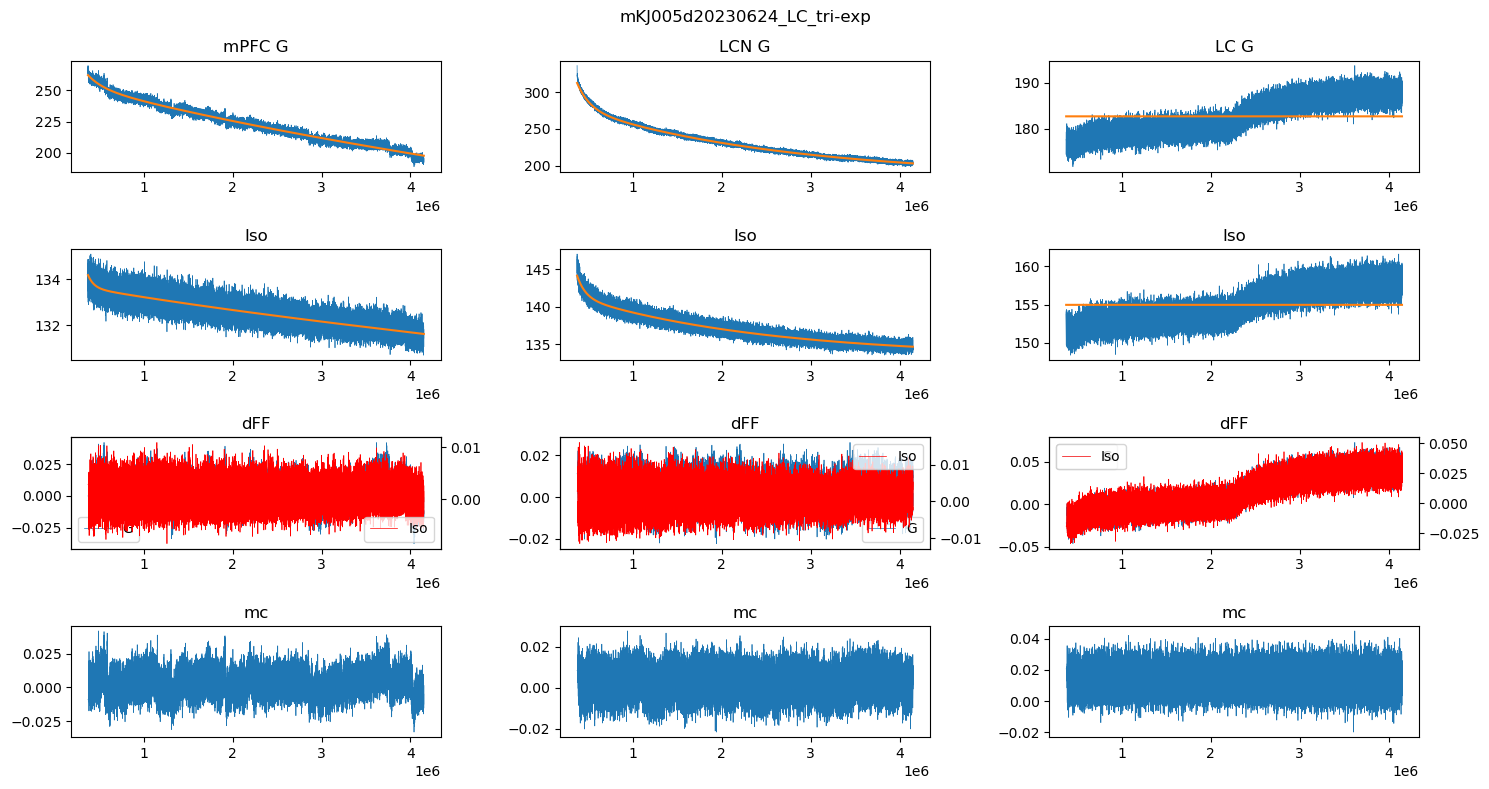

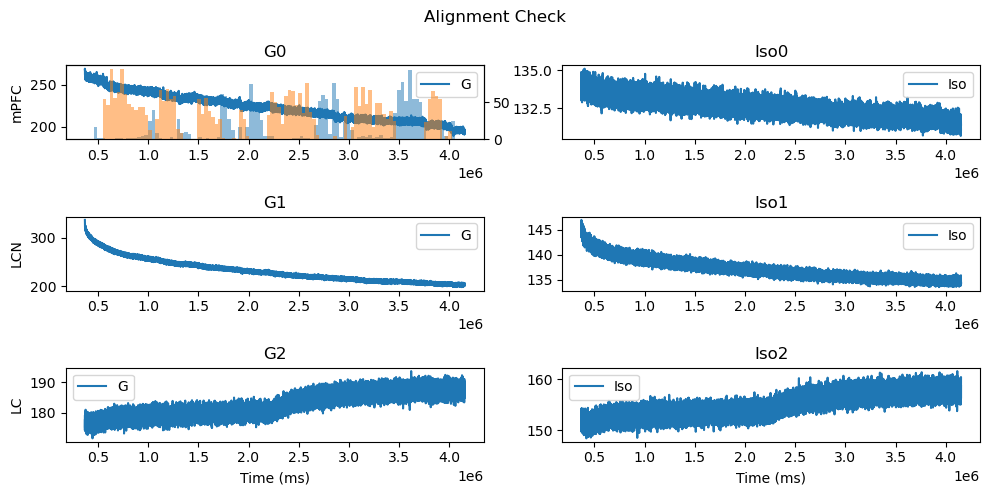

In [8]:
signal_region_prep_CO, params, figs = preprocess_signal_CO(session, label, plot=True, xtol=1e-6, methods=['tri-exp'])
append_FP_data(session, label, signal_region_prep_CO, params)

In [4]:
append_FP_data(session, label, signal_region_prep_CO, params)

Loaded m699461d20240105_combined.pkl and m699461d20240105_combined_params.pkl
Finished writing m699461d20240105_combined.pkl
Finished writing m699461d20240105_combined_params.pkl


#### Load all preprocessed data

In [ ]:
signal_region_prep_updated, params = get_FP_data(session, label)
list(signal_region_prep_updated['G'].keys())

### Batch processing

In [2]:
session_list = get_session_list('photometry', 'all', 'crusIgood')
label = 'CombineWithKH'

In [3]:
session_list = get_session_list('photometry_Gi', 'all', 'Gi_G8')
label = 'Gi'

In [2]:
session_list = get_session_list('photometry', 'all', 'goodFPNewOnly')
label = 'G'
# get_FP_data(session_list[0], label)

#### If there's no preprocessing at all

In [5]:
session_list = get_session_list('photometry', 'all', 'goodFPNewOnly')
label = ''
root = curr_computer()
output = os.path.join(root, 'FP_prep.txt')
def process(session):
    if os.path.exists(output):
        with open(output, 'a') as f:
            f.write(f'{session} started\n')
    else:
        with open(output, 'w') as f:
            f.write(f'{session} started\n')
    # load_session_FP_raw(session, label, channels = ['G', 'Iso'], plot = True)
    get_FP_data(session, label);
    with open(output, 'a') as f:
        f.write(f'{session} done\n')

Parallel(n_jobs=8)(delayed(process)(session) for session in session_list)

c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [3]:
# check if the data is saved correctly
for session in session_list:
    signal_region_prep_updated, params = get_FP_data(session)

Loaded mKJ005d20230624_combined.pkl and mKJ005d20230624_combined_params.pkl
Loaded mKJ005d20230626_combined.pkl and mKJ005d20230626_combined_params.pkl
Loaded mKJ005d20230627_combined.pkl and mKJ005d20230627_combined_params.pkl
Loaded mKJ005d20230628_combined.pkl and mKJ005d20230628_combined_params.pkl
Loaded mKJ005d20230629_combined.pkl and mKJ005d20230629_combined_params.pkl
Loaded mKJ005d20230630_combined.pkl and mKJ005d20230630_combined_params.pkl
Loaded mKJ005d20230701_combined.pkl and mKJ005d20230701_combined_params.pkl
Loaded mKJ005d20230702_combined.pkl and mKJ005d20230702_combined_params.pkl
Loaded mKJ005d20230703_combined.pkl and mKJ005d20230703_combined_params.pkl
Loaded mKJ005d20230704_combined.pkl and mKJ005d20230704_combined_params.pkl
Loaded mKJ005d20230705_combined.pkl and mKJ005d20230705_combined_params.pkl
Loaded mKJ005d20230706_combined.pkl and mKJ005d20230706_combined_params.pkl
Loaded mKJ005d20230707_combined.pkl and mKJ005d20230707_combined_params.pkl
Loaded mKJ00

#### If already preprocessed: Add CO version preprocessing to existing versions

In [9]:
def process_session(session):
    start_time = time.time()  # Record start time
    session_dir = parse_session_string(session)
    
    # Define the output file path
    output_file = os.path.join(session_dir['sortedFolder'], f'{session}_output.txt')
    
    # Ensure the output directory exists
    os.makedirs(session_dir['sortedFolder'], exist_ok=True)
    
    # Open the output file in append mode
    with open(output_file, 'a') as f:
        with redirect_stdout(f):  # Redirect all print statements to the file
            print(f"Processing {session}")
            try:
                signal_region_prep_CO, params, figs = preprocess_signal_CO(session, label, plot=True, xtol=1e-8, methods=['tri-exp'])
                append_FP_data(session, label, signal_region_prep_CO, params)
                plt.close('all')
                print(f"Processing complete for {session}.")

            except Exception as e:
                print(f"An error occurred while processing {session}: {e}")
            finally:
                # Log the processing time
                end_time = time.time()
                elapsed_time = end_time - start_time
                print(f"Processing time for {session}: {elapsed_time:.2f} seconds")

# Run in parallel using joblib
Parallel(n_jobs=8)(delayed(process_session)(session) for session in session_list)
# process_session(session_list[0])


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### File migration

In [39]:
# file migration from pickle to json
for session in session_list:
    print(session)
    session_dir = parse_session_string(session)
    old_file = os.path.join(session_dir['sortedFolder'], f'{session}_combined_params.pkl')
    with open(old_file, 'rb') as f:
        old_params = pickle.load(f)
    new_file = os.path.join(session_dir['sortedFolder'], f'{session}_combined_params_updated.json')
    with open(new_file, 'w') as f:
        json.dump(old_params, f)
    print(f'Finished changing {session}')

m699462d20240113
Loaded m699462d20240113_FP_CombinewithKH.pkl
Loaded m699462d20240113_FP_CombinewithKH.pkl
Loaded m699462d20240113_FP_CombinewithKH.pkl
Loaded m699462d20240113_FP_CombinewithKH.pkl
m699462d20240114
Loaded m699462d20240114_FP_CombinewithKH.pkl
Loaded m699462d20240114_FP_CombinewithKH.pkl
Loaded m699462d20240114_FP_CombinewithKH.pkl
Loaded m699462d20240114_FP_CombinewithKH.pkl
m699462d20240116
Loaded m699462d20240116_FP_CombinewithKH.pkl
Loaded m699462d20240116_FP_CombinewithKH.pkl
Loaded m699462d20240116_FP_CombinewithKH.pkl
Loaded m699462d20240116_FP_CombinewithKH.pkl
m699462d20240117
Loaded m699462d20240117_FP_CombinewithKH.pkl
Loaded m699462d20240117_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699462d20240117_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699462d20240117_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20231221
Loaded m699472d20231221_FP_CombinewithKH.pkl
Loaded m699472d20231221_FP_CombinewithKH.pkl
Loaded m699472d20231221_FP_CombinewithKH.pkl
Loaded m699472d20231221_FP_CombinewithKH.pkl
m699472d20231222
Loaded m699472d20231222_FP_CombinewithKH.pkl
Loaded m699472d20231222_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20231222_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20231222_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240102
Loaded m699472d20240102_FP_CombinewithKH.pkl
Loaded m699472d20240102_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240102_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240102_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240103
Loaded m699472d20240103_FP_CombinewithKH.pkl
Loaded m699472d20240103_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240103_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240103_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240104
Loaded m699472d20240104_FP_CombinewithKH.pkl
Loaded m699472d20240104_FP_CombinewithKH.pkl
Loaded m699472d20240104_FP_CombinewithKH.pkl
Loaded m699472d20240104_FP_CombinewithKH.pkl
m699472d20240105
Loaded m699472d20240105_FP_CombinewithKH.pkl
Loaded m699472d20240105_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240105_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240105_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240106
Loaded m699472d20240106_FP_CombinewithKH.pkl
Loaded m699472d20240106_FP_CombinewithKH.pkl
Loaded m699472d20240106_FP_CombinewithKH.pkl
Loaded m699472d20240106_FP_CombinewithKH.pkl
m699472d20240107
Loaded m699472d20240107_FP_CombinewithKH.pkl
Loaded m699472d20240107_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240107_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240107_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240108
Loaded m699472d20240108_FP_CombinewithKH.pkl
Loaded m699472d20240108_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240108_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240108_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240109
Loaded m699472d20240109_FP_CombinewithKH.pkl
Loaded m699472d20240109_FP_CombinewithKH.pkl
Loaded m699472d20240109_FP_CombinewithKH.pkl
Loaded m699472d20240109_FP_CombinewithKH.pkl
m699472d20240110
Loaded m699472d20240110_FP_CombinewithKH.pkl
Loaded m699472d20240110_FP_CombinewithKH.pkl
Loaded m699472d20240110_FP_CombinewithKH.pkl
Loaded m699472d20240110_FP_CombinewithKH.pkl
m699472d20240111
Loaded m699472d20240111_FP_CombinewithKH.pkl
Loaded m699472d20240111_FP_CombinewithKH.pkl
Loaded m699472d20240111_FP_CombinewithKH.pkl
Loaded m699472d20240111_FP_CombinewithKH.pkl
m699472d20240112
Loaded m699472d20240112_FP_CombinewithKH.pkl
Loaded m699472d20240112_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240112_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240112_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240113
Loaded m699472d20240113_FP_CombinewithKH.pkl
Loaded m699472d20240113_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240113_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240113_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240114
Loaded m699472d20240114_FP_CombinewithKH.pkl
Loaded m699472d20240114_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:62: RuntimeWarning: Mean of empty slice
  mean_psth = np.nanmean(aligned_matrix, axis=0)
c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Loaded m699472d20240114_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:62: RuntimeWarning: Mean of empty slice
  mean_psth = np.nanmean(aligned_matrix, axis=0)
c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Loaded m699472d20240114_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:62: RuntimeWarning: Mean of empty slice
  mean_psth = np.nanmean(aligned_matrix, axis=0)
c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


m699472d20240117
Loaded m699472d20240117_FP_CombinewithKH.pkl
Loaded m699472d20240117_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240117_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240117_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m701707d20231221
Loaded m701707d20231221_FP_CombinewithKH.pkl
Loaded m701707d20231221_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m701707d20231221_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m701707d20231221_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m701707d20231222
Loaded m701707d20231222_FP_CombinewithKH.pkl
Loaded m701707d20231222_FP_CombinewithKH.pkl
Loaded m701707d20231222_FP_CombinewithKH.pkl
Loaded m701707d20231222_FP_CombinewithKH.pkl
m701707d20240103
Loaded m701707d20240103_FP_CombinewithKH.pkl
Loaded m701707d20240103_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m701707d20240103_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m701707d20240103_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m701707d20240104
Loaded m701707d20240104_FP_CombinewithKH.pkl
Loaded m701707d20240104_FP_CombinewithKH.pkl
Loaded m701707d20240104_FP_CombinewithKH.pkl
Loaded m701707d20240104_FP_CombinewithKH.pkl
m701707d20240105
Loaded m701707d20240105_FP_CombinewithKH.pkl
Loaded m701707d20240105_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m701707d20240105_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m701707d20240105_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m701707d20240106
Loaded m701707d20240106_FP_CombinewithKH.pkl
Loaded m701707d20240106_FP_CombinewithKH.pkl
Loaded m701707d20240106_FP_CombinewithKH.pkl
Loaded m701707d20240106_FP_CombinewithKH.pkl
m701707d20240112
Loaded m701707d20240112_FP_CombinewithKH.pkl
Loaded m701707d20240112_FP_CombinewithKH.pkl
Loaded m701707d20240112_FP_CombinewithKH.pkl
Loaded m701707d20240112_FP_CombinewithKH.pkl
m701707d20240113
Loaded m701707d20240113_FP_CombinewithKH.pkl
Loaded m701707d20240113_FP_CombinewithKH.pkl
Loaded m701707d20240113_FP_CombinewithKH.pkl
Loaded m701707d20240113_FP_CombinewithKH.pkl
m701707d20240114
Loaded m701707d20240114_FP_CombinewithKH.pkl
Loaded m701707d20240114_FP_CombinewithKH.pkl
Loaded m701707d20240114_FP_CombinewithKH.pkl
Loaded m701707d20240114_FP_CombinewithKH.pkl
m701707d20240117
Loaded m701707d20240117_FP_CombinewithKH.pkl
Loaded m701707d20240117_FP_CombinewithKH.pkl
Loaded m701707d20240117_FP_CombinewithKH.pkl
Loaded m701707d20240117_FP_CombinewithKH.pkl


In [19]:
# File migration between locations
for session in session_list:
    session_dir = parse_session_string(session)
    # move signal
    old_file = os.path.join(session_dir['photometryPath'], f'{session}_combined.pkl')
    new_folder = session_dir['sortedFolder']
    shutil.move(old_file, new_folder)
    print(f"Finished moving {session}_combined.pkl")
    # move params
    old_file = os.path.join(session_dir['photometryPath'], f'{session}_combined_params.pkl')
    new_folder = session_dir['sortedFolder']
    shutil.move(old_file, new_folder)
    print(f"Finished moving {session}_combined_params.pkl")

Finished moving m749624d20250102_combined.pkl
Finished moving m749624d20250102_combined_params.pkl
Finished moving m749624d20250103_combined.pkl
Finished moving m749624d20250103_combined_params.pkl
Finished moving m749624d20250104_combined.pkl
Finished moving m749624d20250104_combined_params.pkl
Finished moving m749624d20250107_combined.pkl
Finished moving m749624d20250107_combined_params.pkl
Finished moving m749624d20250109_combined.pkl
Finished moving m749624d20250109_combined_params.pkl
Finished moving m749472d20241228_combined.pkl
Finished moving m749472d20241228_combined_params.pkl
Finished moving m749472d20241230_combined.pkl
Finished moving m749472d20241230_combined_params.pkl
Finished moving m749472d20241231_combined.pkl
Finished moving m749472d20241231_combined_params.pkl
Finished moving m749472d20250101_combined.pkl
Finished moving m749472d20250101_combined_params.pkl
Finished moving m749472d20250103_combined.pkl
Finished moving m749472d20250103_combined_params.pkl
Finished m

In [5]:
fiber_json = {"0": "mPFC", "1": "LCN", "2": "LC"}
session_list = get_session_list('photometry', 'all', 'goodFPNewOnly')
for session in session_list:
    session_dir = parse_session_string(session)
    with open(os.path.join(session_dir['photometryPath'], f'{session}.json'), 'w') as f:
        json.dump(fiber_json, f)
    print(f"Finished adding fiber info to {session}")

Finished adding fiber info to mKJ005d20230624
Finished adding fiber info to mKJ005d20230626
Finished adding fiber info to mKJ005d20230627
Finished adding fiber info to mKJ005d20230628
Finished adding fiber info to mKJ005d20230629
Finished adding fiber info to mKJ005d20230630
Finished adding fiber info to mKJ005d20230701
Finished adding fiber info to mKJ005d20230702
Finished adding fiber info to mKJ005d20230703
Finished adding fiber info to mKJ005d20230704
Finished adding fiber info to mKJ005d20230705
Finished adding fiber info to mKJ005d20230706
Finished adding fiber info to mKJ005d20230707
Finished adding fiber info to mKJ005d20230708
Finished adding fiber info to mKJ005d20230710
Finished adding fiber info to mKJ005d20230711
Finished adding fiber info to mKJ005d20230712
Finished adding fiber info to mKJ007d20230624
Finished adding fiber info to mKJ007d20230626
Finished adding fiber info to mKJ007d20230629
Finished adding fiber info to mKJ007d20230630
Finished adding fiber info to mKJ0

### Plot lick artifact

In [ ]:
def process(session):
    # write tmp_dict to json
    signal_region_prep_updated, params = get_FP_data(session, label)
    regions = list(signal_region_prep_updated['G'].keys())
    for region in regions:
        plot_FP_with_licks(session, label, region)
    plt.close('all')
Parallel(n_jobs=8)(delayed(process)(session) for session in session_list[1:])
# process(session_list[0])

In [31]:
# def plot_FP_with_licks_test(session, label, region):
#     session_df, licks_L, licks_R = load_session_df(session)
#     session_dir = parse_session_string(session)
#     signal_region_prep, params = get_FP_data(session, label)
#     licks_L, licks_R, fig = clean_up_licks(licks_L, licks_R, plot=False)
#     parsed_licks_L, _ = parse_lick_trains(licks_L)
#     parsed_licks_R, _ = parse_lick_trains(licks_R)
#     trial_starts = session_df['CSon']
#     licks_in_trial_L = [train_start for train_start in list(parsed_licks_L['train_starts']) if any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
#     licks_in_trial_R = [train_start for train_start in list(parsed_licks_R['train_starts']) if any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
#     licks_out_trial_L = [train_start for train_start in list(parsed_licks_L['train_starts']) if not any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
#     licks_out_trial_R = [train_start for train_start in list(parsed_licks_R['train_starts']) if not any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
#     fig = plt.figure(figsize=(15, 40))
#     colorL = 'b'
#     colorR = 'r'
#     all_channels = [key for key, value in signal_region_prep.items() if 'time' not in key]
#     gs = GridSpec(len(all_channels), 5, figure=fig)
#     for channel_id, channel in enumerate(all_channels):
#         signal = signal_region_prep[channel][region]
#         ax = fig.add_subplot(gs[channel_id, 0])
#         align_signal_to_events(signal, signal_region_prep['time_in_beh'], parsed_licks_L['train_starts'], ax = ax, legend = 'L', color = colorL)
#         align_signal_to_events(signal, signal_region_prep['time_in_beh'], parsed_licks_R['train_starts'], ax = ax, legend = 'R', color = colorR)
#         ax.legend()
#         ax.set_title(f'All licks')
#         ax.set_ylabel(channel)
#         # in vs out trial L
#         ax = fig.add_subplot(gs[channel_id, 1])
#         align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_in_trial_L, ax = ax, color = colorL, legend = 'in')
#         align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_out_trial_L, ax = ax, color = colorR, legend = 'out')
#         ax.legend()
#         ax.set_title(f'In vs out trial L')
#         # in vs out trial R
#         ax = fig.add_subplot(gs[channel_id, 2])
#         align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_in_trial_R, ax = ax, color = colorL, legend = 'in')     
#         align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_out_trial_R, ax = ax, color = colorR, legend = 'out')
#         ax.legend()
#         ax.set_title(f'In vs out trial R')
#         # in left, in vs out trial with gradient of lick lick peak
#         ax = fig.add_subplot(gs[channel_id, 3])
#         num_bins = 3
#         peaks = parsed_licks_L['train_amps']
#         colors_in = color_gradient([1, 0, 0], num_bins+1)
#         colors_out = color_gradient([0, 0, 1], num_bins+1)
#         edges = np.quantile(peaks, np.linspace(0, 1, num_bins+1))
#         for ind in range(num_bins):
#             mask = (peaks>edges[ind]) & (peaks<=edges[ind+1])
#             if np.sum(mask)>2:
#                 align_signal_to_events(signal, signal_region_prep['time_in_beh'], np.array(parsed_licks_L['train_starts'])[mask], ax = ax, color = colors_in[ind+1], legend = f'In trial bin {ind}', plot_error=False)
#         ax.set_title(f'Left licks by lick peak')
#         # in right, in vs out trial with gradient of lick lick peak\
#         ax = fig.add_subplot(gs[channel_id, 4])
#         peaks = parsed_licks_R['train_amps']
#         colors_in = color_gradient([0, 0, 1], num_bins+1)
#         colors_out = color_gradient([0, 0, 1], num_bins+1)
#         edges = np.quantile(peaks, np.linspace(0, 1, num_bins+1))
#         edges[0] = edges[0]-0.01
#         for ind in range(num_bins):
#             mask = (peaks>edges[ind]) & (peaks<=edges[ind+1])
#             if np.sum(mask)>2:
#                 align_signal_to_events(signal, signal_region_prep['time_in_beh'], np.array(parsed_licks_R['train_starts'])[mask], ax = ax, color = colors_in[ind+1], legend = f'In trial bin {ind}', plot_error=False)  
#         ax.set_title(f'Right licks by lick peak')
#     plt.suptitle(f'{session}_{region}')
#     plt.tight_layout()

#     fig.savefig(os.path.join(session_dir['saveFigFolder'], f'{session}_{region}_FP_licks.pdf'))